In [193]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [194]:
from autora.experiment_runner.synthetic.neuroscience import task_switching
from autora.experimentalist.random import random_pool
from autora.experimentalist.grid import grid_pool
from random_pool_with_fixed_variable import random_pool_with_fixed_variable
from regressor_experimentalist import regressor_experimentalist
from autora.state import StandardState, on_state
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from utils import *
from numpy import trapz

## Understanding [Asymmetric] Switch Costs

We define switch cost as the task performance on a repeat trial minus the task performance on a switch trial. We can examine a particular pair of task strengths and see how the Yeung & Monsell model predicts their task performance, and derive the switch cost from those values.

In [197]:
experiment = task_switching.task_switching()
pool = grid_pool(experiment.variables)
experimental_space = experiment.run(pool, added_noise=0.0)
print(experimental_space.loc[(experimental_space['cur_task_strength'] == 0.02) & (experimental_space['alt_task_strength'] == 0.04)])
print(experimental_space.loc[(experimental_space['cur_task_strength'] == 0.04) & (experimental_space['alt_task_strength'] == 0.02)])

   cur_task_strength  alt_task_strength  is_switch  cur_task_performance
2               0.02               0.04          0              0.903635
3               0.02               0.04          1              0.896387
     cur_task_strength  alt_task_strength  is_switch  cur_task_performance
100               0.04               0.02          0              0.920905
101               0.04               0.02          1              0.880224


The switch cost for `cur_task_strength == 0.02` and `alt_task_strength == 0.04` is 0.903635 - 0.896387 or **0.007248**. To calculate asymmetric switch cost, we must also see what happens when we reverse the strength conditions and calculate the switch cost in the reversed case, which is 0.920905 - 0.880224, or **0.040681**. We need to reconceptualize things in terms of strong task strength and weak task strength, and in this case the strong task strength is 0.04 and the weak task strength is 0.02. We define the asymmetric switch cost as a measure of how much harder on performance it is to switch from a weak task to a strong task, compared to switching from a strong task to a weak task, where the switch cost is paradoxically lower:

asymmetric switch cost = (switch cost from strong task to weak task) - (switch cost from weak task to strong task)

In this case, the asymmetric switch cost is 0.040681 - 0.007248, or **0.033433**.

### Plotting the switch cost heat map

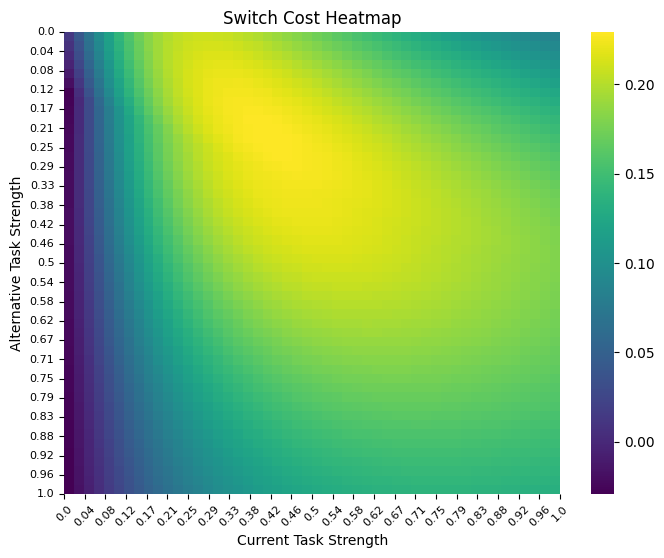

In [199]:
def plot_heatmap(df):
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    
    # Use the actual values for tick positions
    ax = sns.heatmap(df, cmap='viridis')
    
    # Set the tick labels to map to actual data ranges
    grid_size = 50
    num_ticks = 25
    ax.set_xticks(np.linspace(0, grid_size, num_ticks))  # Position on the grid
    ax.set_xticklabels(np.round(np.linspace(0, 1, num_ticks), 2), rotation=45)  # Actual values
    ax.set_yticks(np.linspace(0, grid_size, num_ticks))  # Position on the grid
    ax.set_yticklabels(np.round(np.linspace(0, 1, num_ticks), 2), rotation=0)  # Actual values
    ax.tick_params(axis='both', which='major', labelsize=8)

    # Add labels and title
    plt.title("Switch Cost Heatmap")
    plt.xlabel("Current Task Strength")
    plt.ylabel("Alternative Task Strength")

    plt.show()

# Calculate switch cost for each combination of cur_task_strength and alt_task_strength
switch_costs_df = calculate_switch_costs(experimental_space)
pivot_df = switch_costs_df.pivot(index='alt_task_strength', columns='cur_task_strength', values='switch_cost')
plot_heatmap(pivot_df)

### What's the global maximum for switch costs?

In [78]:
# find row with maximum switch cost in switch_costs_df
max_switch_cost_row = switch_costs_df.loc[switch_costs_df['switch_cost'].idxmax()]
print(f"Highest switch cost: {max_switch_cost_row['switch_cost']} at cur_task_strength={max_switch_cost_row['cur_task_strength']} and alt_task_strength={max_switch_cost_row['alt_task_strength']}")

Highest switch cost: 0.22929210803817202 at cur_task_strength=0.42000000000000004 and alt_task_strength=0.24


### Plotting the asymmetric switch cost heat map
There are 2450 asymmetric switch costs that can be derived from our discrete environment. Out of the 5000 pairs of task strengths, 2550 are meaningless in this context because we need to reframe the data in terms of a strong task and a weak task, requiring one task with a strictly higher strength than the other. This leaves 2450 pairs, whose asymmetric switch costs are calculated by subtracting the cost of switching from the weak task to the strong task, from the cost of switching from the strong task to the weak task.

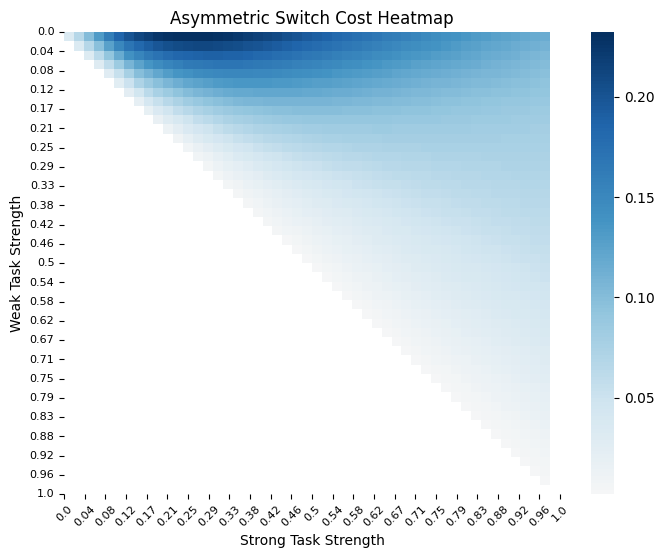

In [141]:
def plot_asymmetric_heatmap(df):
    plt.figure(figsize=(8, 6))
    
    # Create pivot table for heatmap
    pivot_df = df.pivot(index='weak_task_strength', 
                       columns='strong_task_strength', 
                       values='asymmetric_switch_cost')
    
    # Plot heatmap
    ax = sns.heatmap(pivot_df, cmap='RdBu', center=0)  # RdBu to show positive/negative asymmetry
    
    # Set the tick labels
    grid_size = 50
    num_ticks = 25
    ax.set_xticks(np.linspace(0, grid_size, num_ticks))
    ax.set_xticklabels(np.round(np.linspace(0, 1, num_ticks), 2), rotation=45)
    ax.set_yticks(np.linspace(0, grid_size, num_ticks))
    ax.set_yticklabels(np.round(np.linspace(0, 1, num_ticks), 2), rotation=0)
    ax.tick_params(axis='both', which='major', labelsize=8)
    
    # Add labels and title
    plt.title("Asymmetric Switch Cost Heatmap")
    plt.xlabel("Strong Task Strength")
    plt.ylabel("Weak Task Strength")
    plt.show()

# Use the functions
asymmetric_costs_df = get_asymmetric_switch_costs_from_switch_costs(switch_costs_df)
plot_asymmetric_heatmap(asymmetric_costs_df)

#### Validating Asymmetric Switch Cost for the Example

Earlier we derived the asymmetric switch cost manually. Here I'm checking that the function I wrote to calculate this is working correctly, and it is indeed showing what we derived manually.

In [200]:
asymmetric_costs_df.loc[(asymmetric_costs_df['strong_task_strength'] == 0.04) & (asymmetric_costs_df['weak_task_strength'] == 0.02)]

,strong_task_strength,weak_task_strength,asymmetric_switch_cost
0,0.04,0.02,0.033433


### What's the global maximum for asymmetric switch costs?

In [142]:
max_asymmetric_cost_row = asymmetric_costs_df.loc[asymmetric_costs_df['asymmetric_switch_cost'].idxmax()]
print(f"Highest asymmetric switch cost: {max_asymmetric_cost_row['asymmetric_switch_cost']} at weak_task_strength={max_asymmetric_cost_row['weak_task_strength']} and strong_task_strength={max_asymmetric_cost_row['strong_task_strength']}")

Highest asymmetric switch cost: 0.2321510817257728 at weak_task_strength=0.02 and strong_task_strength=0.28


## Setting up the closed loop

In [144]:
def only_experimentalist_closed_loop(experimentalist, experiment, initial_sample_size=1, num_loops=10, mode="switch_cost", experimentalist_args=dict()):
    """
    A closed loop including only the experimentalist and the experiment.
    """
    # initial seed conditions
    initial_conditions = random_pool_with_fixed_variable(experiment.variables, random_state=42, num_sample_groups=initial_sample_size, mode=mode)
    initial_data = experiment.run(initial_conditions, random_state=42)
    # At initial conditions:
    # Initialize the state
    s = StandardState(
        variables = experiment.variables,
        conditions = None,
        experiment_data = initial_data,
    )
    experimentalist_on_state = on_state(experimentalist, output=["conditions"])
    experiment_runner_on_state = on_state(experiment.run, output=["experiment_data"])
    
    # Run the experiment
    for loop in range(num_loops):
        s = experimentalist_on_state(s, **experimentalist_args)
        s = experiment_runner_on_state(s, random_state=42+loop)
        
    return s

## Maximizing Switch Costs
### Using the random experimentalist
The random experimentalist will propose two conditions at a time where they contrast only in `is_switch`. We use the closed loop to run 100 iterations with these conditions and then show the results of the last ten iterations of the loop.

In [153]:
experimentalist = random_pool_with_fixed_variable
experiment = task_switching.task_switching()
num_loops = 100
initial_sample_size = 1
num_sample_groups_per_loop = 1
s = only_experimentalist_closed_loop(experimentalist, experiment, initial_sample_size=initial_sample_size, num_loops=num_loops,
                                     experimentalist_args=dict(num_sample_groups=num_sample_groups_per_loop, fixed_var_name="is_switch"))
random_experimentalist_switch_costs = get_switch_costs_from_ordered_results(s.experiment_data)
random_results = random_experimentalist_switch_costs.assign(
    iteration=range(len(random_experimentalist_switch_costs))
)
print(random_results.tail(10))


     switch_cost  cur_task_strength  alt_task_strength  iteration
91      0.025379               0.10               0.92         91
92      0.209439               0.64               0.40         92
93      0.030339               0.10               0.82         93
94      0.213557               0.50               0.40         94
95      0.210594               0.44               0.56         95
96      0.177403               0.80               0.76         96
97      0.106064               0.24               0.76         97
98      0.059611               0.12               0.66         98
99      0.227535               0.50               0.42         99
100     0.176057               0.92               0.46        100


### Using the regressor experimentalist
The regressor experimentalist will also propose two conditions at a time where they contrast only in `is_switch`. Instead of picking points at random in the space of task strengths, it will use the experiment data to learn about the switch cost's relationship to the task strengths, and propose conditions that might maximize the switch cost. Every iteration of the loop retrains the model with the entirety of the experiment data collected so far. We can see in the last ten iterations of the loop, the results look consistently higher in terms of switch cost compared to the random experimentalist.

In [156]:
experimentalist = regressor_experimentalist
experiment = task_switching.task_switching()
num_loops = 100
initial_sample_size=1
num_sample_groups_per_loop = 1
s = only_experimentalist_closed_loop(experimentalist, experiment, initial_sample_size=initial_sample_size, num_loops=num_loops,
                                     experimentalist_args=dict(fixed_var_name="is_switch"))
regressor_experimentalist_switch_costs = get_switch_costs_from_ordered_results(s.experiment_data)
regressor_results = regressor_experimentalist_switch_costs.assign(
    iteration=range(len(regressor_experimentalist_switch_costs))
)
print(regressor_results.tail(10))

     switch_cost  cur_task_strength  alt_task_strength  iteration
91      0.231226           0.458101           0.332564         91
92      0.208912           0.460185           0.459241         92
93      0.218355           0.382337           0.329731         93
94      0.217747           0.482377           0.307984         94
95      0.241238           0.410675           0.219431         95
96      0.214529           0.618087           0.236124         96
97      0.219734           0.468096           0.416355         97
98      0.227876           0.455852           0.309308         98
99      0.241045           0.477186           0.236103         99
100     0.214281           0.436867           0.241682        100


### Evaluation
#### Visualizing the experimentalists' proposals

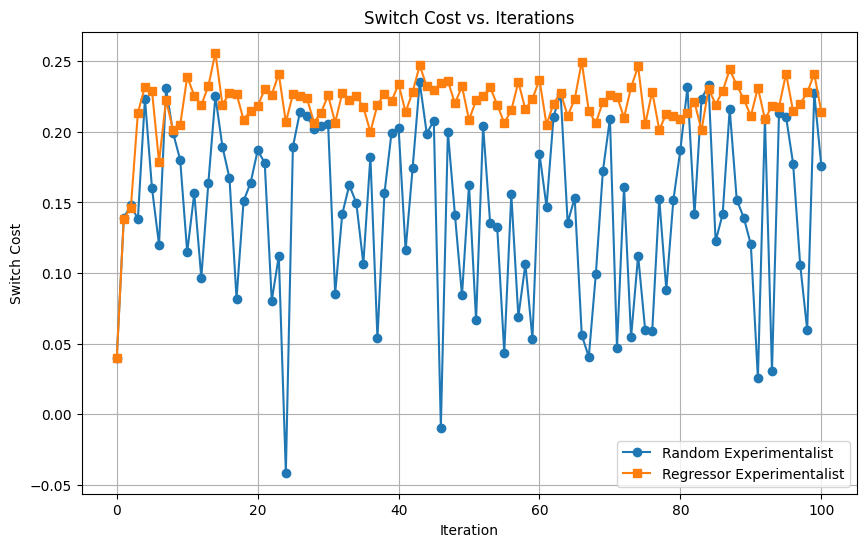

In [157]:
plt.figure(figsize=(10, 6))
plt.plot(random_results['iteration'], random_results['switch_cost'], label='Random Experimentalist', marker='o')
plt.plot(regressor_results['iteration'], regressor_results['switch_cost'], label='Regressor Experimentalist', marker='s')
plt.title('Switch Cost vs. Iterations')
plt.xlabel('Iteration')
plt.ylabel('Switch Cost')
plt.legend()
plt.grid(True)
plt.show()

#### Quantifying the effectiveness of the experimentalists

We can take the final twenty iterations of the loop and see what the average switch costs are of the conditions proposed by each experimentalist, to get an idea of how good their last proposals are.

In [158]:
# First n iterations (e.g., 20)
n = 20
random_avg_switch_cost = random_results['switch_cost'][-n:].mean()
regressor_avg_switch_cost = regressor_results['switch_cost'][-n:].mean()

print(f'Average Switch Cost over last {n} iterations:')
print(f'Random Experimentalist: {random_avg_switch_cost:.4f}')
print(f'Regressor Experimentalist: {regressor_avg_switch_cost:.4f}')

Average Switch Cost over last 20 iterations:
Random Experimentalist: 0.1579
Regressor Experimentalist: 0.2230


To compare the experimentalists over the course of the entire closed loop, we can look at area under the curve.

In [ ]:
# Compute AUC for switch cost vs. iterations
random_auc = trapz(random_results['switch_cost'], dx=1)
regressor_auc = trapz(regressor_results['switch_cost'], dx=1)

print(f'Area Under Curve (AUC):')
print(f'Random Experimentalist: {random_auc:.4f}')
print(f'Regressor Experimentalist: {regressor_auc:.4f}')

Area Under Curve (AUC):
Random Experimentalist: 14.5112
Regressor Experimentalist: 21.9541


## Maximizing Asymmetric Switch Costs
### Using the random experimentalist

In [187]:
experimentalist = random_pool_with_fixed_variable
experiment = task_switching.task_switching()
num_loops = 100
initial_sample_size = 1
num_sample_groups_per_loop = 1
s = only_experimentalist_closed_loop(experimentalist, experiment, initial_sample_size=initial_sample_size, num_loops=num_loops, mode="asymmetric_cost",
                                     experimentalist_args=dict(num_sample_groups=num_sample_groups_per_loop, mode="asymmetric_cost", fixed_var_name="is_switch"))
random_experimentalist_switch_costs = get_switch_costs_from_ordered_results(s.experiment_data)
random_experimentalist_asymmetric_switch_costs = get_asymmetric_switch_costs_from_switch_costs(random_experimentalist_switch_costs)
random_results = random_experimentalist_asymmetric_switch_costs.assign(
    iteration=range(len(random_experimentalist_asymmetric_switch_costs))
)
print(random_results.tail(10))

    strong_task_strength  weak_task_strength  asymmetric_switch_cost  \
87                  0.66                0.16                0.100621   
88                  0.94                0.62                0.033038   
89                  0.52                0.16                0.100984   
90                  0.84                0.48                0.058473   
91                  0.32                0.12                0.119110   
92                  0.60                0.44                0.028271   
93                  0.76                0.42                0.052843   
94                  0.32                0.26                0.046485   
95                  0.90                0.08                0.106692   
96                  1.00                0.46                0.052043   

    iteration  
87         87  
88         88  
89         89  
90         90  
91         91  
92         92  
93         93  
94         94  
95         95  
96         96  


### Using the regressor experimentalist

In [188]:
experimentalist = regressor_experimentalist
experiment = task_switching.task_switching()
num_loops = 100
initial_sample_size = 1
num_sample_groups_per_loop = 1
s = only_experimentalist_closed_loop(experimentalist, experiment, initial_sample_size=initial_sample_size, mode="asymmetric_cost", num_loops=num_loops,
                                     experimentalist_args=dict(fixed_var_name="is_switch", mode="asymmetric_cost"))
regressor_experimentalist_switch_costs = get_switch_costs_from_ordered_results(s.experiment_data)
regressor_experimentalist_asymmetric_switch_costs = get_asymmetric_switch_costs_from_switch_costs(regressor_experimentalist_switch_costs)
regressor_results = regressor_experimentalist_asymmetric_switch_costs.assign(
    iteration=range(len(regressor_experimentalist_asymmetric_switch_costs))
)
print(regressor_results.tail(10))

     strong_task_strength  weak_task_strength  asymmetric_switch_cost  \
91               0.373787            0.028569                0.213438   
92               0.386603            0.053454                0.192658   
93               0.387912            0.041110                0.194083   
94               0.386260            0.009549                0.198176   
95               0.430478            0.047441                0.183022   
96               0.618496            0.013156                0.180524   
97               0.763927            0.238315                0.086045   
98               0.376767            0.014137                0.242581   
99               0.147673            0.028339                0.213211   
100              0.236490            0.028873                0.196736   

     iteration  
91          91  
92          92  
93          93  
94          94  
95          95  
96          96  
97          97  
98          98  
99          99  
100        100  


### Evaluation
#### Visualizing the experimentalists' proposals

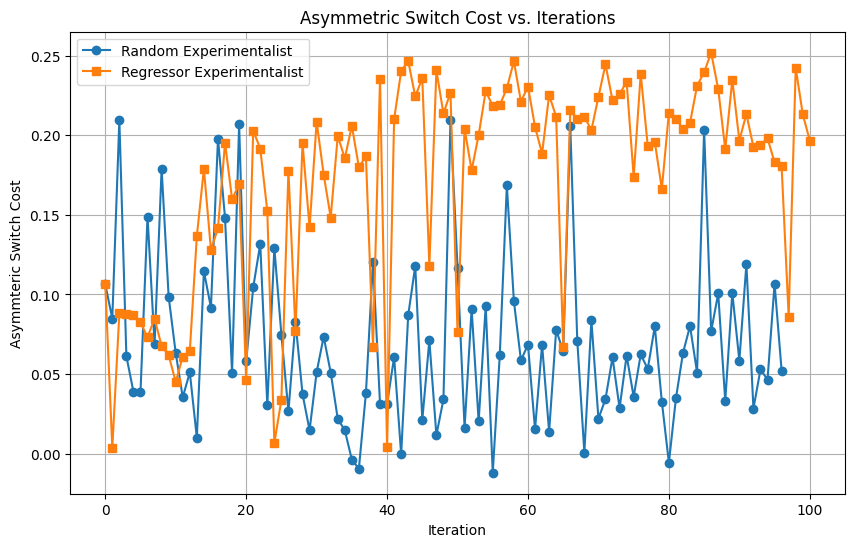

In [189]:
plt.figure(figsize=(10, 6))
plt.plot(random_results['iteration'], random_results['asymmetric_switch_cost'], label='Random Experimentalist', marker='o')
plt.plot(regressor_results['iteration'], regressor_results['asymmetric_switch_cost'], label='Regressor Experimentalist', marker='s')
plt.title('Asymmetric Switch Cost vs. Iterations')
plt.xlabel('Iteration')
plt.ylabel('Asymmteric Switch Cost')
plt.legend()
plt.grid(True)
plt.show()

#### Quantifying the effectiveness of the experimentalists

In [191]:
# First n iterations (e.g., 20)
n = 20
random_avg_switch_cost = random_results['asymmetric_switch_cost'][-n:].mean()
regressor_avg_switch_cost = regressor_results['asymmetric_switch_cost'][-n:].mean()

print(f'Average Asymmtetric Switch Cost over last {n} iterations:')
print(f'Random Experimentalist: {random_avg_switch_cost:.4f}')
print(f'Regressor Experimentalist: {regressor_avg_switch_cost:.4f}')

Average Asymmtetric Switch Cost over last 20 iterations:
Random Experimentalist: 0.0684
Regressor Experimentalist: 0.2049


In [192]:
# Compute AUC for asymmetric switch cost vs. iterations
random_auc = trapz(random_results['asymmetric_switch_cost'], dx=1)
regressor_auc = trapz(regressor_results['asymmetric_switch_cost'], dx=1)

print(f'Area Under Curve (AUC):')
print(f'Random Experimentalist: {random_auc:.4f}')
print(f'Regressor Experimentalist: {regressor_auc:.4f}')

Area Under Curve (AUC):
Random Experimentalist: 6.6985
Regressor Experimentalist: 17.2722
